In [1]:
from itertools import cycle

# Math
import numpy as np
import pandas as pd

# Bio
from Bio import motifs, SeqIO
from Bio.Align import Applications
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

# custom
from unidip import UniDip
from util import *

import matplotlib.pyplot as plt


In [22]:
plt.style.use("seaborn")

In [3]:
muscle_exe = r"./muscle3.8.31_i86linux64"
in_file = r"./MA0852_2/MA0852.2SEQS1K.fasta"
out_file = r"./MA0852_2/MA0852.2Aligned1K.fasta"

In [32]:
MA0852 = pd.read_csv('./MA0852_2/MA0852.2SEQS1K.csv')
seqs = [SeqRecord(Seq(s), id=f"Seq{i}", description="MA0852.2 Sequence from hg38 genome") for i, s in zip(range(MA0852.shape[0]), MA0852['seq'])]

In [5]:
SeqIO.write(seqs, in_file, 'fasta')

1056

In [6]:
muscle_cline = Applications.MuscleCommandline(muscle_exe, input=in_file, out=out_file)
muscle_cline()
print(muscle_cline)

./muscle3.8.31_i86linux64 -in ./MA0852_2/MA0852.2SEQS1K.fasta -out ./MA0852_2/MA0852.2Aligned1K.fasta


In [4]:
alignedSeqs = list(SeqIO.parse(out_file, "fasta"))

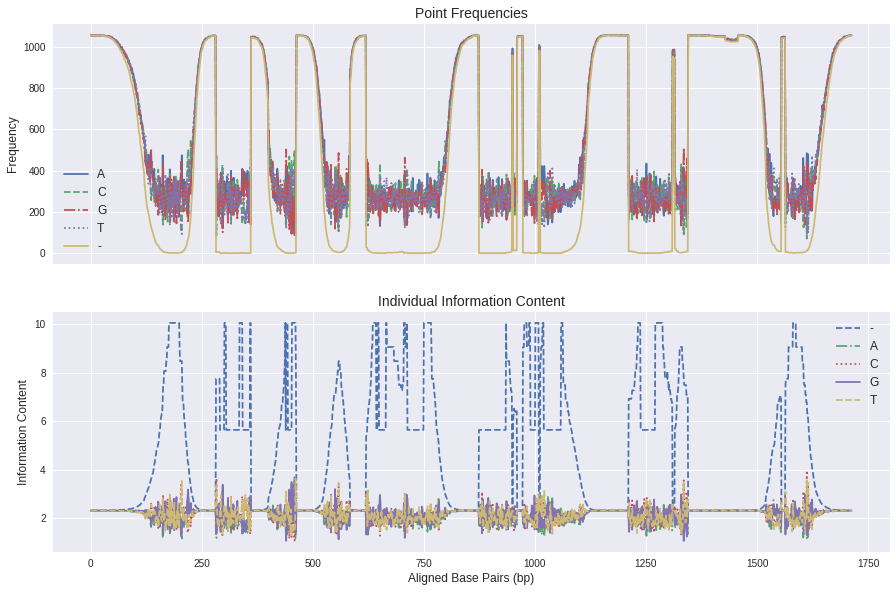

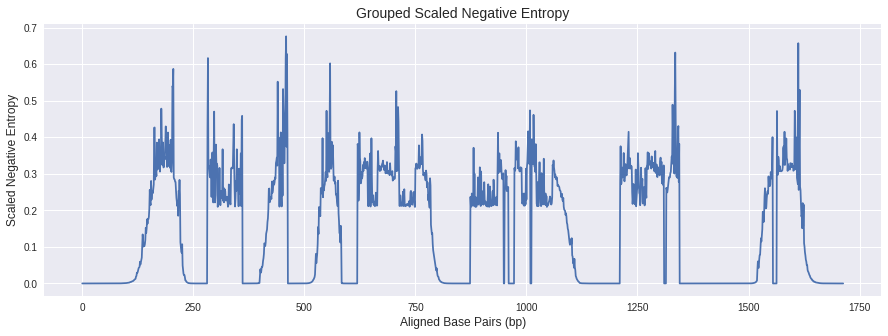

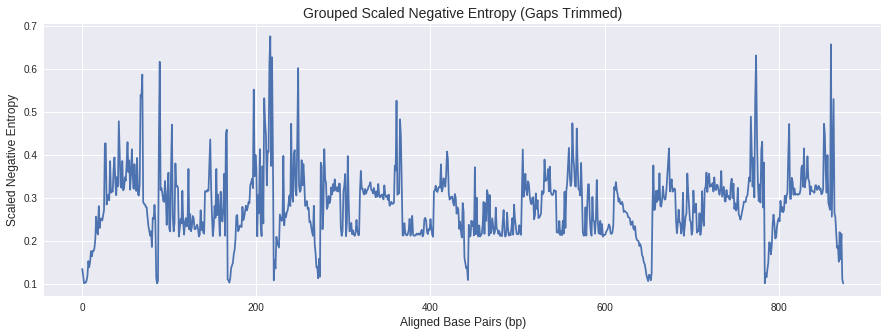

In [23]:
plt.figure(figsize=[15, 15])
lines = ["-","--","-.",":"]
linecycler = cycle(lines)

# Frequency Counts
cts = pd.DataFrame([[let for let in str(s.seq)] for s in alignedSeqs]).apply(pd.value_counts).fillna(0).T.to_dict()
for p, n in cts['-'].items():
    for let in "ACGT":
        cts[let][p] += n

ax1 = plt.subplot('311')
for let in "ACGT-":
    plt.plot(list(cts[let].values()), label=let, ls=next(linecycler))
plt.title("Point Frequencies", fontsize=14)
plt.ylabel("Frequency", fontsize=12)
# plt.xlabel("Aligned Base Pairs (bp)", fontsize=12)
# plt.xticks(range(0,len(strings[0])+1,5), rotation='vertical')
plt.setp(ax1.get_xticklabels(), visible=False)
plt.legend(fontsize=12)

# information content
ic = pd.DataFrame(cts).apply(getInfoCntnt, 1)

plt.subplot('312')
for col in ic:
    plt.plot(ic[col], label=col, ls=next(linecycler))
plt.title("Individual Information Content", fontsize=14)
plt.ylabel("Information Content", fontsize=12)
plt.xlabel("Aligned Base Pairs (bp)", fontsize=12)
# plt.xticks(range(0,len(alignedSeqs[0])+1,5), rotation='vertical')
plt.legend(ic.columns.values, fontsize=12)

plt.show()

# negative scaled entropy
nent = pd.DataFrame(cts).apply(lambda x: 2-shannonEntropy(x), 1) 

plt.figure(figsize=[15, 5])
# plt.subplot('313')
plt.plot(nent, label="Scaled Negative Entropy")
plt.title("Grouped Scaled Negative Entropy", fontsize=14)
plt.ylabel("Scaled Negative Entropy", fontsize=12)
plt.xlabel("Aligned Base Pairs (bp)", fontsize=12)
# plt.xticks(range(0,len(alignedSeqs[0])+1,5), rotation='vertical')
# plt.legend(fontsize=12)

plt.show()

nent_trimmed = nent[nent > 0.1].reset_index()

plt.figure(figsize=[15, 5])
# plt.subplot('313')
plt.plot(nent_trimmed[0], label="Trimmed Scaled Negative Entropy")
plt.title("Grouped Scaled Negative Entropy (Gaps Trimmed)", fontsize=14)
plt.ylabel("Scaled Negative Entropy", fontsize=12)
plt.xlabel("Aligned Base Pairs (bp)", fontsize=12)
# plt.xticks(range(0,len(alignedSeqs[0])+1,5), rotation='vertical')
# plt.legend(fontsize=12)
plt.style.use("seaborn")
plt.show()


In [75]:
res = UniDip(np.array(nent), alpha=.01, is_hist=True, merge_distance=10, debug=False).run()
print(len(res))
print(res)

res1 = UniDip(np.array(nent_trimmed[0]), alpha=0.05, is_hist=True, merge_distance=10, debug=False).run()
print(len(res1))
print(res1)
if len(res1) == 1:
    res1 = [UniDip(np.array(nent_trimmed[0]), is_hist=True, merge_distance=10, debug=False)._get_full_interval(res1[0])]
    print(len(res1))
    print(res1)

10
[(150, 219), (282, 359), (415, 461), (529, 582), (620, 783), (874, 958), (973, 1112), (1211, 1343), (1519, 1553), (1564, 1614)]
2
[(26, 366), (654, 862)]


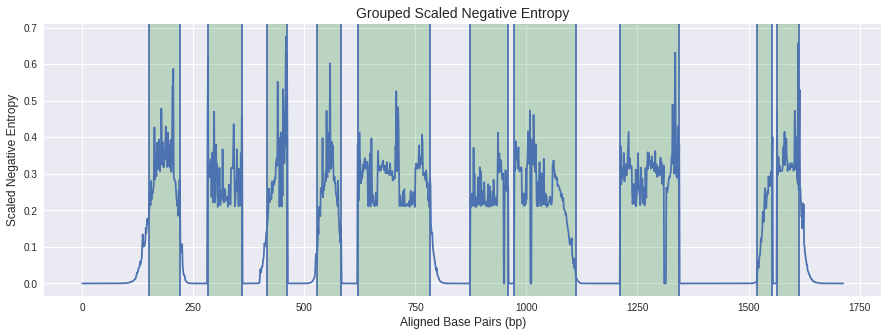

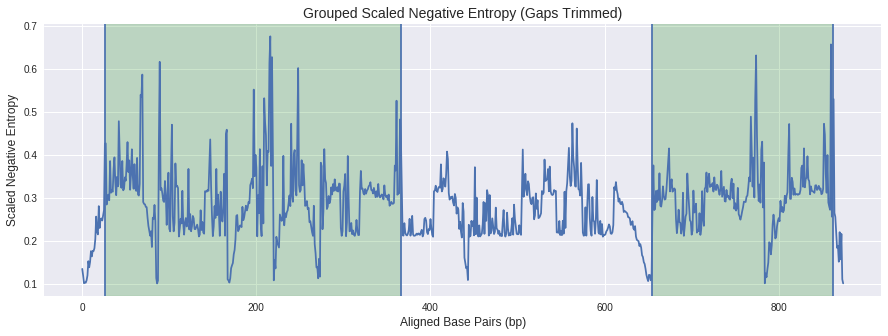

In [76]:
# negative scaled entropy
nent = pd.DataFrame(cts).apply(lambda x: 2-shannonEntropy(x), 1) 

plt.figure(figsize=[15, 5])
# plt.subplot('313')
plt.plot(nent, label="Scaled Negative Entropy")
plt.title("Grouped Scaled Negative Entropy", fontsize=14)
plt.ylabel("Scaled Negative Entropy", fontsize=12)
plt.xlabel("Aligned Base Pairs (bp)", fontsize=12)
# plt.xticks(range(0,len(alignedSeqs[0])+1,5), rotation='vertical')
# plt.legend(fontsize=12)
for lo, hi in res:
    plt.axvline(lo)
    plt.axvline(hi)
    plt.axvspan(lo, hi, color='green', alpha=0.2)

plt.show()

plt.figure(figsize=[15, 5])
# plt.subplot('313')
plt.plot(nent_trimmed[0], label="Scaled Negative Entropy")
plt.title("Grouped Scaled Negative Entropy (Gaps Trimmed)", fontsize=14)
plt.ylabel("Scaled Negative Entropy", fontsize=12)
plt.xlabel("Aligned Base Pairs (bp)", fontsize=12)
# plt.xticks(range(0,len(alignedSeqs[0])+1,5), rotation='vertical')
# plt.legend(fontsize=12)
for lo, hi in res1:
    plt.axvline(lo)
    plt.axvline(hi)
    plt.axvspan(lo, hi, color='green', alpha=0.2)
plt.style.use("seaborn")
plt.show()

In [77]:
scores = score(res, nent)

Cluster 1 mean conservation 0.32086074100948603
Cluster 2 mean conservation 0.2824687946537371
Cluster 3 mean conservation 0.31489988025030785
Cluster 4 mean conservation 0.2708675315286476
Cluster 5 mean conservation 0.2873743814245162
Cluster 6 mean conservation 0.24792245197152757
Cluster 7 mean conservation 0.24361091239654062
Cluster 8 mean conservation 0.29552662416473136
Cluster 9 mean conservation 0.18184979610802682
Cluster 10 mean conservation 0.33918163646506144


In [78]:
scores1 = score(res1, nent_trimmed[0])

Cluster 1 mean conservation 0.297963368606959
Cluster 2 mean conservation 0.30400775165002775


In [79]:
scores

{'cluster1': 0.32086074100948603,
 'cluster10': 0.33918163646506144,
 'cluster2': 0.2824687946537371,
 'cluster3': 0.31489988025030785,
 'cluster4': 0.2708675315286476,
 'cluster5': 0.2873743814245162,
 'cluster6': 0.24792245197152757,
 'cluster7': 0.24361091239654062,
 'cluster8': 0.29552662416473136,
 'cluster9': 0.18184979610802682}

In [80]:
oriSeqs = list(SeqIO.parse(in_file, "fasta"))

def write_trim_align(res, Oseq, Aseq, Tnent):
    trimmedSeqs = []
    for cl in res:
        trimmedSeqs.append([])
        aligned_idxs = Tnent.iloc[cl[0]:cl[1],:]["index"]
        for Oseq, Aseq in zip(sorted(oriSeqs, key=lambda s: s.id), sorted(alignedSeqs, key=lambda s: s.id)):
            assert Oseq.id == Aseq.id, f"{Oseq.id} != {Aseq.id}"
            strt = aligned_idxs.iloc[0]
            stop = aligned_idxs.iloc[-1]
            nsqs = Oseq[strt-str(Aseq.seq).count('-', 0, strt) - 15 : stop-str(Aseq.seq).count('-', 0, stop) + 15]
            trimmedSeqs[-1].append(nsqs) if len(nsqs) > 0 else None
    return trimmedSeqs

In [81]:
clusterSeqs = write_trim_align(res1, oriSeqs, alignedSeqs, nent_trimmed)

In [18]:
for i, cl in zip(range(1, len(clusterSeqs) + 1), clusterSeqs):
    SeqIO.write(cl, f'./MA0852_2/TrimmedCluster{i}.fasta', 'fasta')

In [82]:
def RSE(labs, tss):
    return list(map(lambda a, b: np.sqrt((a - b) ** 2), labs, tss))
    
def get_trim_diffs(res, alignedA, alignedT, labs, func):
    trimStartSites, diffs = [], []
    for cl in res:
        idxs = alignedT.iloc[cl[0]:cl[1],:]["index"]
        trimStartSites.append([])
        for seq in alignedA:
            strt = idxs.iloc[0]
            trimStartSites[-1].append(strt-str(seq.seq).count('-', 0, strt))
    
    for tss in trimStartSites:
        diffs.append(func(labs, tss))
    
    return [sum(d) for d in diffs], diffs

def get_coverage(res, alignedA, alignedT, labs):
    trimStartSites, trimEndSites, diffs = [], [], []
    for cl in res:
        idxs = alignedT.iloc[cl[0]:cl[1],:]["index"]
        trimStartSites.append([])
        trimEndSites.append([])
        for seq in alignedA:
            strt = idxs.iloc[0]
            end = idxs.iloc[-1]
            trimStartSites[-1].append(strt-str(seq.seq).count('-', 0, strt))
            trimEndSites[-1].append(end-str(seq.seq).count('-', 0, end))
    
    for pss, pes in zip(trimStartSites, trimEndSites):
        is_covered = list(map(lambda ms, me, ps, pe: (ps < ms < pe or ps < me < pe), labs['mstart'], labs['mstop'], pss, pes))
        diffs.append(is_covered)
    
    return [sum(d) / len(d) for d in diffs], diffs

In [83]:
per_cov, cov_raw = get_coverage(res1, alignedSeqs, nent_trimmed, MA0852[['mstart', 'mstop']])
per_cov

[0.39678030303030304, 0.2490530303030303]

In [73]:
sum_dff, dffs = get_trim_diffs(res1, alignedSeqs, nent_trimmed, MA0852.mstop, RSE)

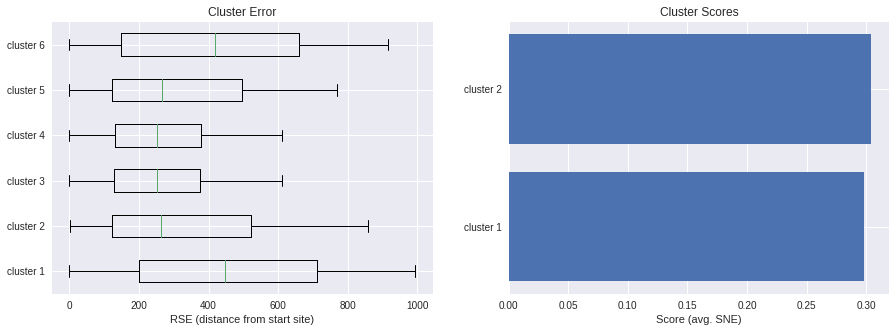

In [74]:
plt.figure(figsize=[15, 5])

ax = plt.subplot("121")
plt.boxplot(dffs,  0, 'rs', 0)
plt.title("Cluster Error")
plt.xlabel("RSE (distance from start site)")
ax.set_yticks(range(1, len(dffs) + 1))
ax.set_yticklabels([f"cluster {i + 1}" for i in range(len(dffs))])

ax = plt.subplot("122")
plt.barh([f"cluster {i + 1}" for i in range(len(scores1))], list(scores1.values()), align="center")
plt.title("Cluster Scores")
plt.xlabel("Score (avg. SNE)")

# plt.ylabel("")
plt.show()

In [ ]:
plt.figure(figsize=[15, 15])
lines = ["-","--","-.",":"]
linecycler = cycle(lines)

# Frequency Counts
cts = pd.DataFrame([[let for let in str(s.seq)] for s in oriSeqs]).apply(pd.value_counts).fillna(0).T.to_dict()

# negative scaled entropy
nent = pd.DataFrame(cts).apply(lambda x: 2-shannonEntropy(x), 1) 
nent_trimmed = nent[nent > 0.1].reset_index()

plt.figure(figsize=[15, 5])
# plt.subplot('313')
plt.plot(nent_trimmed[0], label="Trimmed Scaled Negative Entropy")
plt.title("Grouped Scaled Negative Entropy (Gaps Trimmed)", fontsize=14)
plt.ylabel("Scaled Negative Entropy", fontsize=12)
plt.xlabel("Aligned Base Pairs (bp)", fontsize=12)
# plt.xticks(range(0,len(alignedSeqs[0])+1,5), rotation='vertical')
# plt.legend(fontsize=12)
plt.style.use("seaborn")
plt.show()
